# requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from src.load_data import load_data

fbirn_data, demographics = load_data()
timeseries = fbirn_data["data"]
diagnoses = fbirn_data["diags"]
sexes = fbirn_data["sexes"]
ages = fbirn_data["ages"]

print(demographics)
print(f"# subjects: {timeseries.shape[0]}, # timepoints: {timeseries.shape[1]}, # features: {timeseries.shape[2]}")

     Category          Statistic/Label   Value
0   Diagnosis             Count HC (0)  160.00
1   Diagnosis             Count SZ (1)  151.00
2         Sex           Count Male (0)  230.00
3         Sex         Count Female (1)   81.00
4         Age                      Min   18.00
5         Age                      Max   62.00
6         Age                     Mean   37.88
7         Age                  Std Dev   11.24
8    Age Bins  Count Bin 0 (18.0-32.7)  119.00
9    Age Bins  Count Bin 1 (32.7-47.3)  117.00
10   Age Bins  Count Bin 2 (47.3-62.0)   75.00
# subjects: 311, # timepoints: 140, # features: 53


In [2]:
ica_coords = pd.read_csv("data/ICN_coordinates.csv")
domains = ica_coords["Domain"]
# update nans with previous value
domains = domains.fillna(method='ffill')
domains = np.asarray(domains.tolist())

change_idx = np.flatnonzero(np.r_[True, domains[1:] != domains[:-1]])
# change_idx marks the start index of each group
starts = change_idx
# compute ends (inclusive) indices for each group
ends = np.r_[starts[1:] - 1, domains.size - 1]
centers = ((starts + ends) / 2.0).tolist()
# boundaries are positions between pixels: (end + 0.4) for each group except last
boundaries = (ends[:-1] + 0.4).tolist()

group_names_full = [domains[s] for s in starts]
group_names = ["SC", "AU", "SM", "VIS", "CC", "DM", "CB"]  # short names

/var/folders/c7/h35llrbd2h76sn_0f75rjyz00000gq/T/ipykernel_77856/2963762152.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  domains = domains.fillna(method='ffill')


# 0. First milestone
- Write a general setup for the experiments
- Find important features using stattests 
- Train classifiers, inspect the features that they found important

In [3]:
from src.utils import corrcoef_batch

pcc_matrices = corrcoef_batch(timeseries)
pcc_matrices.shape

(311, 53, 53)

In [14]:
def analyze_group_differences(data, labels):
    groups = np.unique(labels)
    group_data = [data[labels == g] for g in groups]

    stat, p_value = stats.ttest_ind(group_data[0], group_data[1], axis=0, equal_var=False)
    return stat, p_value

def plot_heatmap(matrix, ax, cmap='bwr', vmin=None, vmax=None):
    cax = ax.imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks(centers)
    ax.set_xticklabels(group_names)
    ax.set_yticks(centers)
    ax.set_yticklabels(group_names)
    for boundary in boundaries:
        ax.axhline(boundary, color='k', linewidth=1.5)
        ax.axvline(boundary, color='k', linewidth=1.5)
    return cax


/Users/ppopov1/miniconda3/envs/pile/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


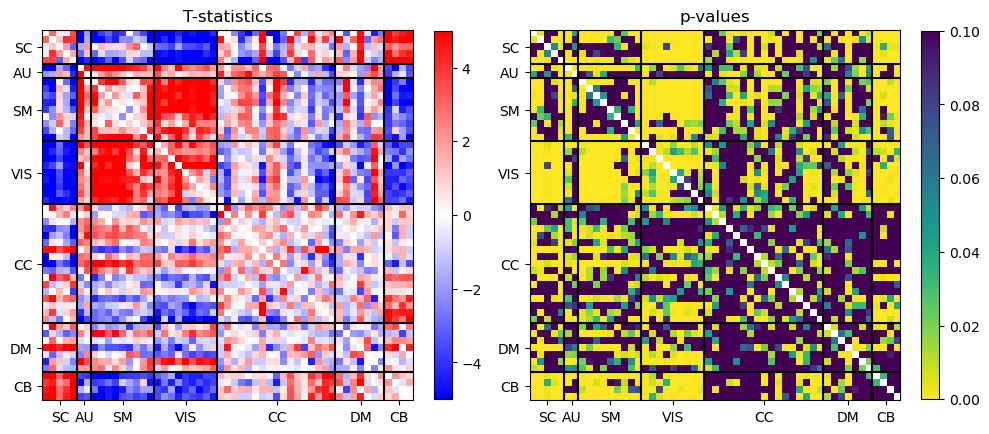

In [24]:
stat, p_value = analyze_group_differences(pcc_matrices, diagnoses)

boundaries = (ends[:-1] + 0.4).tolist()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cax1 = plot_heatmap(stat, ax[0], vmin=-5, vmax=5)
ax[0].set_title("T-statistics")
fig.colorbar(cax1, ax=ax[0], fraction=0.045)  
cax2 = plot_heatmap(p_value, ax[1], vmin=0, vmax=0.1, cmap='viridis_r')
ax[1].set_title("p-values")
fig.colorbar(cax2, ax=ax[1], fraction=0.045)  
plt.tight_layout()
plt.show()